In [ ]:
%%capture
!pip install transformers bertopic accelerate bitsandbytes xformers adjustText datamapplot umap-learn

In [ ]:
from google.colab import drive

import pandas as pd

from huggingface_hub import notebook_login

from torch import cuda
from torch import bfloat16

import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

from sklearn.feature_extraction.text import CountVectorizer

import datamapplot
import numpy as np
import matplotlib.pyplot as plt

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

import nltk
from nltk.corpus import stopwords



In [ ]:
# Request access to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BERTopic/preprocessed_ai_jobs_subset_275.csv')

dataset

,job_id,company_name,title,description,original_listed_time,expiry,cleaned_description,cleaned_title
0,2269442456,navXcom,Computer Scientist,Are you passionate about developing cutting-ed...,2024-04-19 02:31:59,2024-05-19 02:31:59,passionate developing software deep space comm...,computer scientist
1,3245063922,Saxon AI,Data Architect,Request: Data ArchitectLocation: San Francisco...,2024-04-19 14:27:02,2024-05-19 14:27:02,request data architectlocation san francisco c...,data architect
2,3533320307,NLB Services,Java architect / Lead Java developer,Position: Java architect / Lead Java developer...,2024-04-11 17:08:59,2024-05-11 17:08:59,position java architect lead java developerloc...,java architect lead java developer
3,3586167732,StyleAI,Senior Software Engineer,"StyleAI is the AI-powered, all-in-one unified ...",2024-04-17 23:33:53,2024-05-17 23:33:53,styleai unified marketing platform business am...,senior software engineer
4,3728459637,HireBus,Principal Backend Engineer,Principal Backend Engineer - Join HireBus and ...,2024-04-18 20:04:36,2024-05-18 20:04:36,principal backend engineer join hirebus revolu...,principal backend engineer
...,...,...,...,...,...,...,...,...
2218,3906256303,Overview,Full Stack Engineer (San Fransisco),Company Overview\n\nOverview.ai is a leading i...,2024-04-19 22:49:16,2024-05-19 23:07:57,company overview leading innovator computer vi...,full stack engineer san fransisco
2219,3906257658,Accenture,SAP Program Delivery Lead - Aerospace & Defense,"We Are: \n\nAccenture’s SAP practice, and we b...",2024-04-19 23:13:36,2024-05-19 23:29:24,accenture sap practice bring new life using de...,sap program delivery lead aerospace defense
2220,3906259133,Scorebird,Embedded Software Engineer,"Senior Embedded Developer\n- BS degree in CS, ...",2024-04-19 22:53:01,2024-05-19 22:53:01,senior embedded developer b degree c ee relate...,embedded software engineer
2221,3906259147,Advantis Global is becoming INSPYR Solutions,Data Engineer II,About This Featured Opportunity\n\nWe are look...,2024-04-19 22:48:21,2024-05-19 22:59:36,featured opportunity looking data engineer occ...,data engineer ii


In [ ]:
# Fill missing values in the "description" column with an empty string
dataset["cleaned_description"] = dataset["cleaned_description"].fillna("")

# Ensure all values are strings
dataset["cleaned_description"] = dataset["cleaned_description"].astype(str)

# Combine titles and descriptions into a single column
dataset["combined"] = dataset["cleaned_title"] + " " + dataset["cleaned_description"]

# Convert combined column to a list
titles = dataset["cleaned_title"]
description = dataset["cleaned_description"]
combined = dataset["combined"].astype(str)

# Extract timestamps
timestamps = dataset['original_listed_time'].to_list()

# Preview an entry
print(f"Example combined entry: {dataset['combined'].iloc[0]}")

Example combined entry: computer scientist passionate developing software deep space communication navigation system ready jumpstart career become part core team exciting opportunity seeking talented computer scientist voluntary unpaid basis join dynamic team contribute creation innovative mobile application support nasa collaborate talented team engineer software developer product manager turn idea secured software


In [ ]:
def compute_coherence_score(topic_model, combined, topics, coherence_type='c_v'):
    """
    Computes the coherence score for a BERTopic model.

    Parameters:
    - topic_model: BERTopic
        The trained BERTopic model.
    - combined: List[str]
        The list of input documents used in training the model.
    - topics: List[int]
        The topic assignments for the documents.
    - coherence_type: str
        The type of coherence metric to use. Default is 'c_v'.

    Returns:
    - float
        The computed coherence score.
    """
    # Group documents by topic
    documents = pd.DataFrame({"Document": combined, "ID": range(len(combined)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Create tokens, dictionary, and corpus
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract topic words
    topic_words = [
        [word for word, _ in topic_model.get_topic(topic)]
        for topic in range(len(set(topics)) - 1)
    ]

    # Compute coherence

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence=coherence_type
    )
    coherence = coherence_model.get_coherence()

    print(f"Coherence Score ({coherence_type}): {coherence}")
    return coherence

In [ ]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(combined, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
job_stopwords = ["experience", "team", "work", "job", "position", "company", "customer"]

custom_stopwords = stopwords.words("english") + job_stopwords

# Use the updated stopwords in the vectorizer
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

In [ ]:
umap_model = UMAP(
    n_neighbors=5,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    verbose=True)

hbdscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True)

# Training BERTopic model to find best hyperparameters
topic_model = BERTopic(

  # Sub-models
  vectorizer_model=vectorizer_model,
  umap_model=umap_model,
  hdbscan_model=hbdscan_model,

  # Hyperparameters
  min_topic_size=20,
  n_gram_range=(1,3),
  verbose=True,
  calculate_probabilities=True
)

# Train model
topics, probs = topic_model.fit_transform(combined, embeddings)

2025-01-07 13:46:14,432 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, n_neighbors=5, random_state=42, verbose=True)
Tue Jan  7 13:46:14 2025 Construct fuzzy simplicial set
Tue Jan  7 13:46:19 2025 Finding Nearest Neighbors
Tue Jan  7 13:46:22 2025 Finished Nearest Neighbor Search
Tue Jan  7 13:46:25 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


2025-01-07 13:46:29,490 - BERTopic - Dimensionality - Completed ✓
2025-01-07 13:46:29,491 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-07 13:46:29,947 - BERTopic - Cluster - Completed ✓
2025-01-07 13:46:29,953 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-07 13:46:30,515 - BERTopic - Representation - Completed ✓


Tue Jan  7 13:46:29 2025 Finished embedding


In [ ]:
# Create topics over time
topics_over_time = topic_model.topics_over_time(combined, timestamps)

# Plot topics over time
topic_model.visualize_topics_over_time(topics_over_time, topics=[0])

2025-01-07 13:53:15,574 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1898) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
1898it [00:31, 59.77it/s]


In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,417,-1_data_learning_system_skill,"[data, learning, system, skill, development, b...",[senior lead engineer generative ai product en...
1,0,286,0_learning_machine_ai_model,"[learning, machine, ai, model, engineer, devel...",[senior software engineer company codemonk ven...
2,1,220,1_cloud_data_aws_architect,"[cloud, data, aws, architect, skill, engineer,...",[cloud automation manager job id 2405140 locat...
3,2,174,2_data_business_analytics_management,"[data, business, analytics, management, skill,...",[bie mode description looking talented busines...
4,3,71,3_product_ai_sale_business,"[product, ai, sale, business, project, managem...",[lead project manager role well fargo seeking ...
5,4,51,4_azure_data_databricks_etl,"[azure, data, databricks, etl, sql, factory, p...",[azure tech lead job title azure tech lead loc...
6,5,40,5_developer_code_coding_proficient,"[developer, code, coding, proficient, software...",[software developer software developer contrac...
7,6,38,6_code_proficient_chatbots_coding,"[code, proficient, chatbots, coding, problem, ...",[software engineer dataannotation committed cr...
8,7,37,7_proficient_coding_chatbots_problem,"[proficient, coding, chatbots, problem, able, ...",[data analyst dataannotation committed creatin...
9,8,37,8_ai_gen_generative_ml,"[ai, gen, generative, ml, model, azure, learni...",[applied ai engineer generative ai video dedic...


In [ ]:
score = compute_coherence_score(topic_model, combined, topics, coherence_type='c_v')


Coherence Score (c_v): 0.6131140132766927


In [ ]:
reduced_outliers = topic_model.reduce_outliers(
    documents=combined,
    topics=topics,
    strategy="probabilities",
    probabilities=probs,
)

In [ ]:
topic_model.update_topics(docs=combined, topics=reduced_outliers)

2025-01-05 17:18:01,181 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
score2 = compute_coherence_score(topic_model, combined, topics, coherence_type='c_v')


Coherence Score (c_v): 0.5808522575327882


In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,358,0_learning_machine_machine learning_ai,"[learning, machine, machine learning, ai, mode...",[senior software engineer company codemonk ven...
1,1,276,1_data_experience_cloud_aws,"[data, experience, cloud, aws, skill, year, se...",[cloud automation manager job id 2405140 locat...
2,2,227,2_data_business_experience_team,"[data, business, experience, team, analytics, ...",[bie mode description looking talented busines...
3,3,76,3_product_ai_team_customer,"[product, ai, team, customer, business, sale, ...",[lead project manager role well fargo seeking ...
4,4,67,4_data_azure_databricks_azure data,"[data, azure, databricks, azure data, experien...",[azure tech lead job title azure tech lead loc...
5,5,40,5_software developer_developer_software_code,"[software developer, developer, software, code...",[software developer software developer contrac...
6,6,38,6_code_problem_proficient_chatbots,"[code, problem, proficient, chatbots, coding, ...",[software engineer dataannotation committed cr...
7,7,37,7_problem_proficient_coding_chatbots,"[problem, proficient, coding, chatbots, able, ...",[data analyst dataannotation committed creatin...
8,8,40,8_ai_experience_generative_gen,"[ai, experience, generative, gen, gen ai, lear...",[applied ai engineer generative ai video dedic...
9,9,72,9_automation_system_electrical_maintenance,"[automation, system, electrical, maintenance, ...",[principal engineer job title principal engine...


In [ ]:
# topics_to_merge = [[3, 6],
#                    [2, 10]]
# topic_model.merge_topics(combined, topics_to_merge)


100%|██████████| 55/55 [02:45<00:00,  3.02s/it]


In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=5, n_components=2, min_dist=0.1, metric='cosine', random_state=42).fit_transform(embeddings)


In [ ]:
topic_model.visualize_topics()

In [ ]:
plot = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)
plot

In [ ]:
fig1 = topic_model.visualize_topics()
fig2 = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

# Save the figure as an HTML file
fig1.write_html("/content/drive/My Drive/Colab Notebooks/Intertopic_dist_map2.html")
fig2.write_html("/content/drive/My Drive/Colab Notebooks/Documents_map2.html")


# Llama2 Model

Huggingface token:



In [ ]:
notebook_login()

In [ ]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


In [ ]:
# Set quantization configuration for loading large models with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,             # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",     # Use normalized float 4-bit precision
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Compute type for better performance
)

In [ ]:
# Model name for topic label generating
model_id = "meta-llama/Llama-2-7b-chat-hf"

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id, use_auth_token=True)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=

In [ ]:
# Our text generator
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Device set to use cuda:0


In [ ]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?
 nobody likes a know-it-all, but I'm here to help! 😊

Quantization is like a magic trick where we make things smaller. Imagine you have a big box of toys, and inside that box, there are lots of different colors and shapes. But sometimes, it's hard to remember all the different colors and shapes, so we take a picture of the box and then we only remember the picture. That's kind of like what quantization does!

So, when we quantize something, like an image or sound, we take all the different colors and shapes (or sounds) and we group them together into just a few groups. We can only remember the groups, not all the individual colors and shapes (or sounds). It's like taking a picture of the box instead of trying to remember every single toy inside.

For example, let's say we have an image with lots of different colors, like red, blue, green, and yellow. We could group those colors into just two groups: "red" and "not red".

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful, and honest assistant for labeling topics. Your primary task is to identify AI-related competences and skills from the topics and generate concise labels based exclusively on the keywords provided.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
The topic is described by the following keywords: 'generative AI, transformer, GPT, BERT, multimodal, text generation, fine-tuning, large language models, creative AI'.

Based solely on these keywords, create a concise 1-5 word label for this topic. Focus specifically on AI-related competences and skills:
- Example: For the keywords above, the label would be "Generative AI".

Ensure the label directly reflects the AI-related competences, skills, or tools. If the topic is not AI-related, indicate it with the label "Not AI-Related", and nothing more.

[/INST] Generative AI
"""

# Main prompt for labeling topics
main_prompt = """
[INST]
I have a topic described by the following keywords: '[KEYWORDS]'.

Based solely on these keywords, create a concise 1-5 word label for this topic. Follow these rules:
- Focus entirely on AI-related competences, skills, or tools described by the keywords.
- If the topic is not AI-related, label it as "Not AI-Related".
- Ignore generic or unrelated terms and emphasize technical or AI-specific terms.

Return only the label, and nothing else.
[/INST]
"""

# Combine the system, example, and main prompts into one
prompt = system_prompt + example_prompt + main_prompt


In [ ]:
# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# Representation model
representation_model = {
    "Llama2": llama2,
}


In [ ]:
topic_model.update_topics(docs=combined, representation_model=representation_model)

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Llama2,Representative_Docs
0,0,358,0_learning_machine_machine learning_ai,"[learning, machine, machine learning, ai, mode...","[Machine Learning, , , , , , , , , ]",[senior software engineer company codemonk ven...
1,1,276,1_data_experience_cloud_aws,"[data, experience, cloud, aws, skill, year, se...","[Cloud Development, , , , , , , , , ]",[cloud automation manager job id 2405140 locat...
2,2,227,2_data_business_experience_team,"[data, business, experience, team, analytics, ...","[Business AI, , , , , , , , , ]",[bie mode description looking talented busines...
3,3,76,3_product_ai_team_customer,"[product, ai, team, customer, business, sale, ...","[AI Management, , , , , , , , , ]",[lead project manager role well fargo seeking ...
4,4,67,4_data_azure_databricks_azure data,"[data, azure, databricks, azure data, experien...","[Data Engineering, , , , , , , , , ]",[azure tech lead job title azure tech lead loc...
5,5,40,5_software developer_developer_software_code,"[software developer, developer, software, code...","[AI Developer, , , , , , , , , ]",[software developer software developer contrac...
6,6,38,6_code_problem_proficient_chatbots,"[code, problem, proficient, chatbots, coding, ...","[AI Chatbots, , , , , , , , , ]",[software engineer dataannotation committed cr...
7,7,37,7_problem_proficient_coding_chatbots,"[problem, proficient, coding, chatbots, able, ...","[Train AI, , , , , , , , , ]",[data analyst dataannotation committed creatin...
8,8,40,8_ai_experience_generative_gen,"[ai, experience, generative, gen, gen ai, lear...","[Gen AI, , , , , , , , , ]",[applied ai engineer generative ai video dedic...
9,9,72,9_automation_system_electrical_maintenance,"[automation, system, electrical, maintenance, ...","[Automation, , , , , , , , , ]",[principal engineer job title principal engine...


In [ ]:
topic_info = topic_model.get_topic_info()

# If `Llama2` column has lists, clean it to extract the first item or the label
topic_info['Llama2'] = topic_info['Llama2'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
topic_info


,Topic,Count,Name,Representation,Llama2,Representative_Docs
0,0,358,0_learning_machine_machine learning_ai,"[learning, machine, machine learning, ai, mode...",Machine Learning,[senior software engineer company codemonk ven...
1,1,276,1_data_experience_cloud_aws,"[data, experience, cloud, aws, skill, year, se...",Cloud Development,[cloud automation manager job id 2405140 locat...
2,2,227,2_data_business_experience_team,"[data, business, experience, team, analytics, ...",Business AI,[bie mode description looking talented busines...
3,3,76,3_product_ai_team_customer,"[product, ai, team, customer, business, sale, ...",AI Management,[lead project manager role well fargo seeking ...
4,4,67,4_data_azure_databricks_azure data,"[data, azure, databricks, azure data, experien...",Data Engineering,[azure tech lead job title azure tech lead loc...
5,5,40,5_software developer_developer_software_code,"[software developer, developer, software, code...",AI Developer,[software developer software developer contrac...
6,6,38,6_code_problem_proficient_chatbots,"[code, problem, proficient, chatbots, coding, ...",AI Chatbots,[software engineer dataannotation committed cr...
7,7,37,7_problem_proficient_coding_chatbots,"[problem, proficient, coding, chatbots, able, ...",Train AI,[data analyst dataannotation committed creatin...
8,8,40,8_ai_experience_generative_gen,"[ai, experience, generative, gen, gen ai, lear...",Gen AI,[applied ai engineer generative ai video dedic...
9,9,72,9_automation_system_electrical_maintenance,"[automation, system, electrical, maintenance, ...",Automation,[principal engineer job title principal engine...


In [ ]:
topic_info.to_csv('/content/drive/My Drive/Colab Notebooks/topic_info_AI.csv', index=False)


In [ ]:
# Extract Llama2 labels from topic info
topic_info = topic_model.get_topic_info()
llama2_labels = topic_info['Llama2'].tolist()

# Assign labels to each document based on topics
document_topics = topic_model.get_document_info(combined)['Topic']
labels = [llama2_labels[topic] if topic != -1 else "Unlabeled" for topic in document_topics]

In [ ]:
flattened_labels = [
    label[0] if isinstance(label, list) and len(label) > 0 else "Unlabeled"
    for label in labels
]

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Generated using BERTopic and datamapplot'}>)

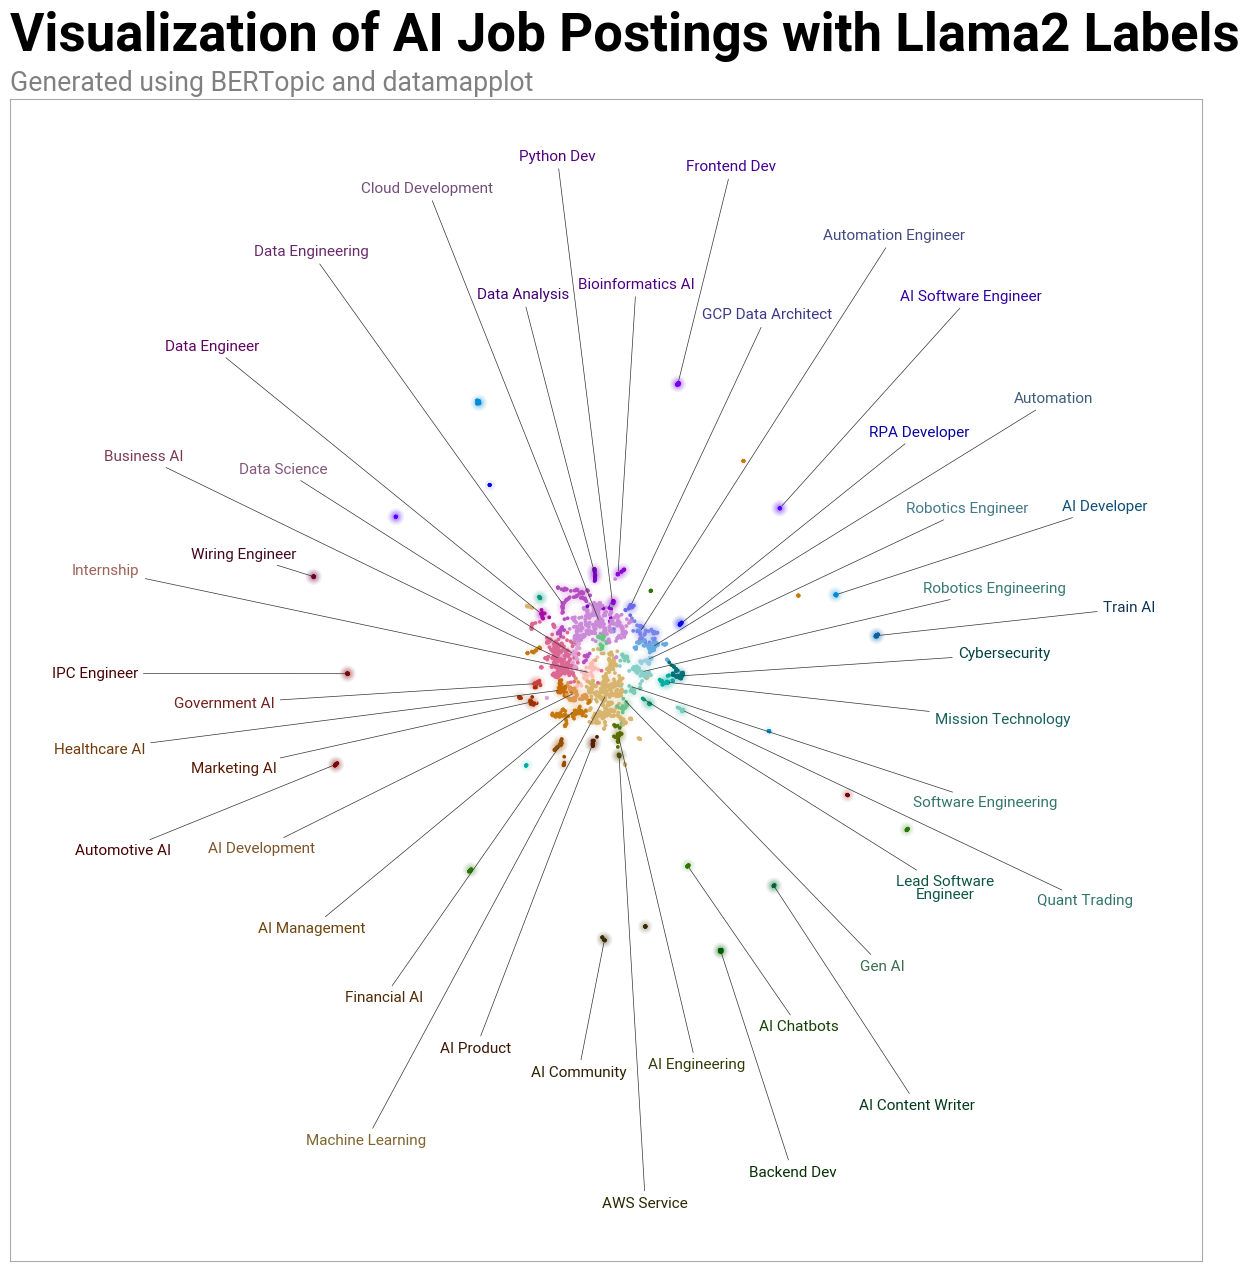

In [ ]:
datamapplot.create_plot(
    data_map_coords=reduced_embeddings,  # Use your 2D embeddings
    labels=flattened_labels,               # Correct argument for labels
    title="Visualization of AI Job Postings with Llama2 Labels",
    sub_title="Generated using BERTopic and datamapplot",
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)